In [1]:
!nvidia-smi

Wed Sep  8 07:03:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import os
from PIL import Image
import matplotlib.image as mpimg
import math
import numpy as np

import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn as nn

In [ ]:
path='/content/drive/MyDrive/BanglaDigit/training-a'
pathDir=os.listdir(path)
R_channel = 0
G_channel = 0
B_channel = 0

total_pixel = 0
for idx in range(len(pathDir)):
    filename = pathDir[idx]
    img = mpimg.imread(os.path.join(path, filename))

    total_pixel = total_pixel + img.shape[0] * img.shape[1]

    R_channel = R_channel + np.sum(img[:, :, 0])
    G_channel = G_channel + np.sum(img[:, :, 1])
    B_channel = B_channel + np.sum(img[:, :, 2])

R_mean = R_channel / total_pixel
G_mean = G_channel / total_pixel
B_mean = B_channel / total_pixel

In [3]:
mean=[0.8750035673528975, 0.8463234409957352, 0.8874216696869045]
mean

[0.8750035673528975, 0.8463234409957352, 0.8874216696869045]

In [ ]:
R_channel = 0
G_channel = 0
B_channel = 0

total_pixel = 0
for idx in range(len(pathDir)):
    filename = pathDir[idx]
    img = mpimg.imread(os.path.join(path, filename))

    total_pixel = total_pixel + img.shape[0] * img.shape[1]

    R_channel = R_channel + np.sum((img[:, :, 0]-R_mean)**2)
    G_channel = G_channel + np.sum((img[:, :, 1]-G_mean)**2)
    B_channel = B_channel + np.sum((img[:, :, 2]-B_mean)**2)

R_std = math.sqrt(R_channel / total_pixel)
G_std = math.sqrt(G_channel / total_pixel)
B_std = math.sqrt(B_channel / total_pixel)

In [4]:
std=[0.07046917287748444, 0.07732078873722921, 0.0762934488480062]
std

[0.07046917287748444, 0.07732078873722921, 0.0762934488480062]

In [5]:
class DigitDataset(data.Dataset):
    def __init__(self, path, mean, std):
        self.path=path
        self.images=[]
        self.labels=[]
        self.mean=mean
        self.std=std
        
        self.df=pd.read_csv(os.path.join(path,'training-a.csv'))
        self.df.drop(['original filename', 'scanid', 'database name original', 
                 'contributing team', 'database name'], inplace=True, axis=1)
        
        for index,i in self.df.iterrows():
            self.images.append(i['filename'])
            self.labels.append(i['digit'])
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,idx):
        i=self.images[idx]
        d=self.labels[idx]
        
        img=Image.open(os.path.join(self.path,'training-a/'+i)).convert('RGB')
        
        transform=transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=self.mean, std=self.std)])
        img=transform(img)
        
        return img, d

In [6]:
dataset=DigitDataset('/content/drive/MyDrive/BanglaDigit', mean, std)
len(dataset)

19702

In [8]:
dataset.__getitem__(1)

(tensor([[[ 0.4382,  0.3269,  0.3825,  ...,  0.1043,  0.1599,  0.1599],
          [ 0.3825,  0.2712,  0.2712,  ...,  0.0486,  0.0486,  0.1043],
          [ 0.2156,  0.1599,  0.0486,  ..., -0.0627, -0.0627, -0.1183],
          ...,
          [ 0.3269,  0.3825,  0.3269,  ...,  0.1599,  0.1599,  0.2712],
          [ 0.2156,  0.3269,  0.2156,  ...,  0.1599,  0.0486,  0.1043],
          [ 0.1599,  0.2156,  0.1043,  ..., -0.0070,  0.0486,  0.1043]],
 
         [[ 0.4153,  0.4660,  0.5167,  ...,  0.1617,  0.1109,  0.1109],
          [ 0.3138,  0.3138,  0.3645,  ...,  0.0602, -0.0412, -0.1426],
          [ 0.2631,  0.3645,  0.2124,  ..., -0.0412, -0.1426, -0.0919],
          ...,
          [ 0.4660,  0.3645,  0.2631,  ...,  0.2124,  0.2631,  0.2124],
          [ 0.1617,  0.1109,  0.0095,  ...,  0.1109,  0.0602,  0.2631],
          [ 0.4153,  0.4660,  0.3138,  ...,  0.0095,  0.0602,  0.1617]],
 
         [[ 0.4476,  0.3962,  0.4476,  ...,  0.1392,  0.1392,  0.1906],
          [ 0.1392,  0.1392,

In [9]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [46]:
class ExperimentalModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes=10):
        super().__init__()
        self.fc1=nn.Linear(input_dim, hidden_dim)
        self.act1=nn.ReLU()
        
        self.fc2=nn.Linear(hidden_dim, hidden_dim)
        self.fc3=nn.Linear(hidden_dim, hidden_dim)
        self.act2=nn.ReLU()
        
        self.fc4=nn.Linear(hidden_dim, hidden_dim)
        self.fc5=nn.Linear(hidden_dim, hidden_dim)
        self.act3=nn.ReLU()
        
        self.fc6=nn.Linear(hidden_dim, hidden_dim)
        self.act4=nn.ReLU()
        
        self.classifier=nn.Linear(hidden_dim,num_classes)
    
    
    def forward(self, img):
        img=img.view(-1,3*180*180)
        
        dense1=self.fc1(img)
        dense1=self.act1(dense1)
        
        dense2=self.fc2(dense1)
        dense3=self.fc3(dense2)
        dense3=self.act2(dense3)
        
        dense4=self.fc4(dense3)
        dense5=self.fc5(dense4)
        dense5=self.act3(dense5)
        
        dense6=self.fc6(dense5)
        dense6=self.act4(dense6)
        
        fc=self.classifier(dense6)
        
        return fc

In [47]:
input_dim=3*180*180
hidden_dim=200

model=ExperimentalModel(input_dim, hidden_dim).to(device)
model

ExperimentalModel(
  (fc1): Linear(in_features=97200, out_features=200, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (act2): ReLU()
  (fc4): Linear(in_features=200, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=200, bias=True)
  (act3): ReLU()
  (fc6): Linear(in_features=200, out_features=200, bias=True)
  (act4): ReLU()
  (classifier): Linear(in_features=200, out_features=10, bias=True)
)

In [48]:
class ModelExperiment:
    def __init__(self, model, dataset, batch_size, learning_rate, iteration):
        self.dataset=dataset
        self.batch_size=batch_size
        self.learning_rate=learning_rate
        self.iteration=iteration
        self.hidden_dim=hidden_dim
        self.model=model.to(device)
        
        self.indices=list(range(len(self.dataset)))
        self.train_indices=self.indices[:int(len(self.dataset)*0.7)]
        self.val_indices=self.indices[int(len(self.dataset)*0.7):int(len(self.dataset)*0.8)]
        self.test_indices=self.indices[int(len(self.dataset)*0.8):]
        
        self.train_sampler=torch.utils.data.SubsetRandomSampler(self.train_indices)
        self.val_sampler=torch.utils.data.SubsetRandomSampler(self.val_indices)
        self.test_sampler=torch.utils.data.SubsetRandomSampler(self.test_indices)
        
        self.train_loader=torch.utils.data.DataLoader(dataset=self.dataset, batch_size=self.batch_size, sampler=self.train_sampler)
        self.val_loader=torch.utils.data.DataLoader(dataset=self.dataset, batch_size=self.batch_size, sampler=self.val_sampler)
        self.test_loader=torch.utils.data.DataLoader(dataset=self.dataset, batch_size=self.batch_size, sampler=self.test_sampler)
        
        self.optimizer=torch.optim.SGD(self.model.parameters(), lr=self.learning_rate, momentum=0.9)
        self.criterion=nn.CrossEntropyLoss()
        
        self.len_train_set=len(self.train_indices)
        self.len_val_set=len(self.val_indices)
        self.len_test_set=len(self.test_indices)

        self.epoch=int(iteration/((self.len_train_set/self.batch_size)))
        
        self.train_accuracy=[]
        self.train_loss=[]

        self.early_stopping=False
        self.prev_acc=0.0
        self.val_acc=0.0
        
        
    def run(self):
        print('<----------Start Training----------->')
        accuracy=0.0
        loss_=0.0
        for num_epoch in range(self.epoch):
            running_acc, running_loss, num_updates=0.0,0.0,0.0
            val_loss, validation_acc=0.0,0.0
            for i,d in self.train_loader:
                i=i.to(device)
                d=d.to(device)
                
                self.optimizer.zero_grad()
                
                outputs=self.model(i)
                
                loss=self.criterion(outputs, d.long())
                _,pred=torch.max(outputs,1)
                
                loss.backward()
                self.optimizer.step()
                
                with torch.no_grad():
                    running_loss+=loss.item()
                    running_acc+=(pred==d).sum()
                
                num_updates+=1 

                print(f'Epoch {num_epoch}:  Batch-{int(num_updates)}:  Accuracy: {running_acc/float(num_updates*self.batch_size)}, Loss: {running_loss/float(num_updates*self.batch_size)}')
        
            with torch.no_grad():
              for im,answer in self.val_loader:
                img=im.to(device)
                ans=answer.to(device)

                output=self.model(img)
          
                loss=self.criterion(output, ans.long())
                _,a_pred=torch.max(output,1)

                val_loss+=loss.item()
                validation_acc+=(a_pred==ans).sum()
              
              val_loss=float(val_loss)/float(self.len_val_set)
              validation_acc=float(validation_acc)/float(self.len_val_set)

              if validation_acc>=self.prev_acc:
                self.prev_acc=validation_acc
              else:
                self.val_acc=self.prev_acc
                self.early_stopping=True
            
            accuracy=float(running_acc)/float(self.len_train_set)
            loss_=float(running_loss)/float(self.len_train_set)

            self.train_accuracy.append(accuracy)
            self.train_loss.append(loss_)

            print(f'\nDone with Epoch {num_epoch},  Accuracy: {accuracy},  Loss: {loss_}\n')
            print(f'Validation Accuracy:  {validation_acc}')

            if self.early_stopping:
              print('\n<---------Finished Training------------>\n')
              break
            torch.save(model.state_dict(), '/content/drive/MyDrive/BanglaDigit/checkpoint2.pkt')
            
        print('Validation Accuracy:  ',self.val_acc)
                    

In [49]:
exp=ModelExperiment(model, dataset, 20, 0.01, 20000)
exp.run()

<----------Start Training----------->
Epoch 0:  Batch-1:  Accuracy: 0.10000000149011612, Loss: 0.11587356328964234
Epoch 0:  Batch-2:  Accuracy: 0.125, Loss: 0.1153094232082367
Epoch 0:  Batch-3:  Accuracy: 0.11666667461395264, Loss: 0.1150881807009379
Epoch 0:  Batch-4:  Accuracy: 0.11250000447034836, Loss: 0.11501455903053284
Epoch 0:  Batch-5:  Accuracy: 0.08999999612569809, Loss: 0.11512959718704224
Epoch 0:  Batch-6:  Accuracy: 0.09166666865348816, Loss: 0.11504165132840474
Epoch 0:  Batch-7:  Accuracy: 0.08571428805589676, Loss: 0.1151057243347168
Epoch 0:  Batch-8:  Accuracy: 0.07500000298023224, Loss: 0.11526840478181839
Epoch 0:  Batch-9:  Accuracy: 0.0833333358168602, Loss: 0.11517588959799872
Epoch 0:  Batch-10:  Accuracy: 0.09999999403953552, Loss: 0.11513262152671815
Epoch 0:  Batch-11:  Accuracy: 0.11363635957241058, Loss: 0.11509269909425215
Epoch 0:  Batch-12:  Accuracy: 0.12083333730697632, Loss: 0.11505581438541412
Epoch 0:  Batch-13:  Accuracy: 0.11923076957464218, L

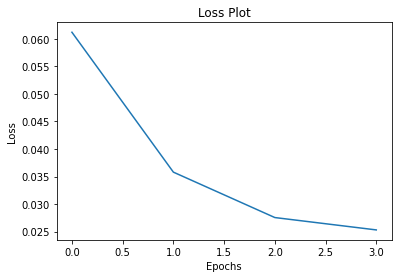

In [50]:
import matplotlib.pyplot as plt
epochs=[]
for i in range(4):
    epochs.append(i)
plt.plot(epochs,exp.train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

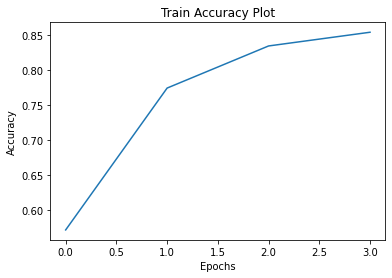

In [51]:
import matplotlib.pyplot as plt
epochs=[]
for i in range(4):
    epochs.append(i)
plt.plot(epochs,exp.train_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy Plot')
plt.show()

In [52]:
def evaluate():
  test_loss=0.0
  test_acc=0.0

  with torch.no_grad():
    for im,answer in exp.test_loader:
      img=im.to(device)
      ans=answer.to(device)

      output=exp.model(img)

      loss=exp.criterion(output, ans.long())
      _,a_pred=torch.max(output,1)

      test_loss+=loss.item()
      test_acc+=(a_pred==ans).sum()
      #print(test_acc)
    
    test_loss=float(test_loss)/float(exp.len_test_set)
    test_acc=float(test_acc)/float(exp.len_test_set)
      
  return test_acc

In [53]:
evaluate()

0.7084496320730779